In [1]:
import functools
import jax
import os
import html

from datetime import datetime
from jax import numpy as jp
import matplotlib.pyplot as plt

from IPython.display import HTML, clear_output, display

import flax
from brax import envs
from brax.io import model
from brax.io import json
from brax.io import html

from src.pods.pods import train
from src.env.Pendulum import InvertedPendulum
import pickle


In [2]:
from jax.lib import xla_bridge
print(xla_bridge.get_backend().platform)
print(jax.devices())

cpu
[CpuDevice(id=0)]


In [3]:
env = InvertedPendulum()
state = jax.jit(env.reset)(rng=jax.random.PRNGKey(seed=0))

#HTML(html.render(env.sys, [state.pipeline_state]))

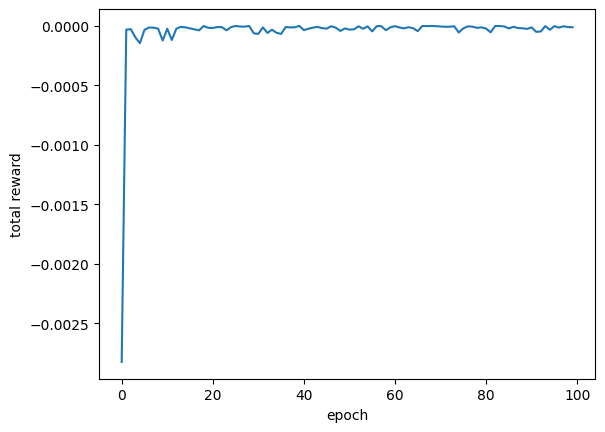

big epoch: 99 small epoch: 0 Loss 1.0515699e-06


In [4]:

def progress_f(x_data,y_data,epoch,reward):
    x_data.append(epoch)
    y_data.append(reward)
    clear_output(wait=True)
    plt.xlabel('epoch')
    plt.ylabel('total reward')
    plt.plot(x_data, y_data)
    plt.show()

policy = train(env,trajectory_length=10,num_samples=8,epochs=100,alpha_a=1e-5,progress_fn=progress_f)

In [6]:
f = f = open("traj.txt", "w")
inference_fn = policy()
rollout = []
rng = jax.random.PRNGKey(seed=1)
state = env.reset(rng=rng)
for _ in range(1000):
  rollout.append(state.pipeline_state)
  act_rng, rng = jax.random.split(rng)
  act = inference_fn(state.obs)
  state = env.step(state, act)
print(rollout,file=f)

HTML(html.render(env.sys.replace(dt=env.dt), rollout))